# NZU price dynamics 

This notebook (i) takes historical data on the price of New Zealand Units (NZUs) in the New Zealand Emissions Trading Scheme (NZ-ETS) and (ii) performs Monte Carlo analysis to make projections into the future.

## Monte Carlo
Assuming price dynamics follows [geometric Brownian motion (GBM)](https://en.wikipedia.org/wiki/Geometric_Brownian_motion), it can be simulated using a discrete-time Markov chain Monte Carlo (MCMC) by repeatedly applying the following recurrence relation, 

$$
p^{(t+1)} = p^{(t)}\exp(d+\xi), 
$$

where $t \in \{0,1,2,\dots\}$ indexes regular timesteps (which could represent days, months, or years), $d$ is a constant drift parameter, and $\xi$ is a normally distributed random variable, i.e. $\xi \sim \mathcal{N}(0,\sigma)$, with the standard deviation $\sigma$ (and variance $\sigma^{2}$) determining price volatility. Note that the underlying assumption here is that price will move in steps that are lognormally distributed, i.e.

$$
r^{(t+1)} := \ln\left(\frac{p^{(t+1)}}{p^{(t)}}\right) \sim \mathcal{N}(d,\sigma).
$$

The two parameters, $d$ and $\sigma$, can be inferred from data on past prices, i.e. a historical dataset $P_{H} = \{p^{(t)}, p^{(t-1)}, \dots, p^{(t-M)}\}$, from which $R_{H} = \{r^{(t)}, \dots, r^{(t-M+1)}\}$ can be calculated. The latter set of values will have an arithmetic mean $\bar{r}$ and variance $\sigma_{r}^{2}$, calculated
using 
$$
\bar{r} = \frac{1}{M}\sum_{i=0}^{M-1}r^{(t-i)} \quad \mathrm{and} \quad \sigma_{r}^{2} = \frac{1}{M-1} \sum_{i=0}^{M-1} (r^{(t-i)} - \bar{r})^{2},
$$

and, according to [this Investopedia article](https://www.investopedia.com/terms/m/montecarlosimulation.asp), the drift parameter can then be calculated using the formula

$$
d_{r} = \bar{r} - \frac{\sigma_{r}^{2}}{2}. 
$$

This formula seems similar to the "risk-neutral drift" in [these notes on geometric Brownian motion](http://www.columbia.edu/~ks20/FE-Notes/4700-07-Notes-GBM.pdf).

A simulated Markov chain $i$ starting from $p^{(0)}$ at $t=0$ should end up at a value
$$
p_{i}^{(N)} = p^{(0)} \exp\left(Nd + \sum_{t=1}^{N}\xi_{n}\right)
$$
at $t=N$. Repeating the simulation starting with the same initial condition will produce another Markov chain $j$ with a different endpoint, i.e. $p_{j}^{(N)} \neq p_{i}^{(N)}$. Repeating the simulation sufficiently many times should reveal that the endpoints will be lognormally distributed with the mean value of $Nd_{r}$ and standard deviation of $\sqrt{N}\sigma_{r}$, i.e.

$$
\ln\left(\frac{p^{(N)}}{p^{(0)}}\right) \sim \mathcal{N}(Nd_{r},\sqrt{N}\sigma_{r}).
$$

## NZU price dynamics

### Historical price data

In [1]:
import pandas as pd

<AxesSubplot: xlabel='date', ylabel='NZD'>

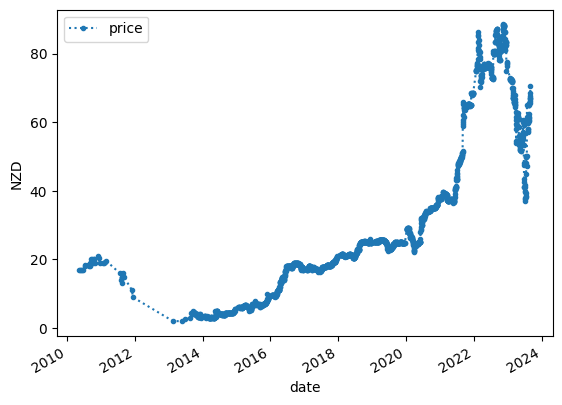

In [2]:
source='./price-data-scrape/nzu_price_raw_data.csv'
df = pd.read_csv(source, index_col='date', parse_dates=[0])
df.drop(columns=['url'], inplace=True)
df.plot(linestyle=':', marker='.',ylabel='NZD')

Datapoints before September 2013 are sparse, so we will discard them, and then resample the remaining data into weekly and monthly intervals. Found this [StackOverflow question](https://stackoverflow.com/questions/41513324/python-pandas-drop-rows-of-a-timeserie-based-on-time-range) quite helpful.

In [3]:
start_date = pd.to_datetime('2013-9-1')
df = df.loc[(df.index > start_date)]

In [4]:
df_w = df.resample('W').mean()
df_w.ffill(inplace=True) # forward fill missing values
df_m = df.resample('M').mean()
print(len(df), len(df_w), len(df_m))

2113 521 121


(0.0, 92.78)

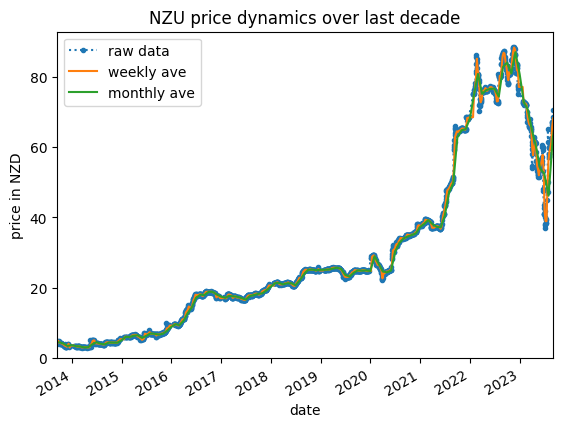

In [5]:
ax = df.plot(linestyle = ':', 
             marker = '.',
             ylabel = 'price in NZD',
             title = 'NZU price dynamics over last decade')
df_w.plot(ax = ax, label = 'weekly')
df_m.plot(ax = ax)
ax.legend(labels = ['raw data','weekly ave','monthly ave'])
ax.set_xlim(min(df.index),max(df.index))
ax.set_ylim(0)

### Distribution of past returns
Look at the distribution of the logarithm of geometric returns, i.e. $\ln\left(\frac{p^{(t+1)}}{p^{(t)}}\right)$,  derived from the raw data as well as the weekly and the monthly averaged data. 

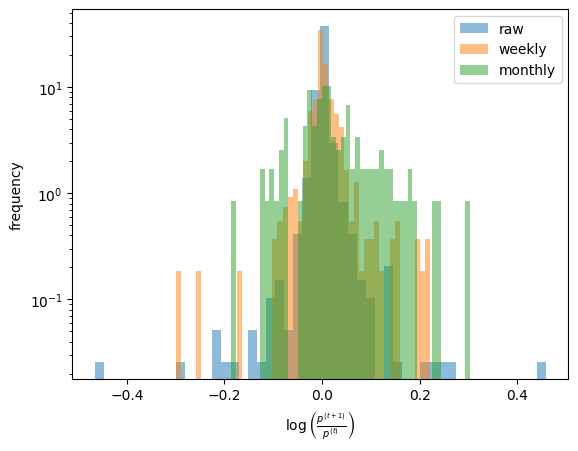

In [6]:
import matplotlib.pyplot as plt 
import numpy as np
logreturns = [np.log(df['price'].iloc[i]/df['price'].iloc[i-1]) for i in range(1,len(df['price']))]
logreturns_w = [np.log(df_w['price'].iloc[i]/df_w['price'].iloc[i-1]) for i in range(1,len(df_w['price']))]
logreturns_m = [np.log(df_m['price'].iloc[i]/df_m['price'].iloc[i-1]) for i in range(1,len(df_m['price']))]
plt.hist(logreturns, bins=50, density=True, alpha=0.5)
plt.hist(logreturns_w, bins=50, density=True, alpha=0.5)
plt.hist(logreturns_m, bins=50, density=True, alpha=0.5)
plt.legend(['raw','weekly','monthly'])
plt.yscale('log')
plt.xlabel(r'$\log\left(\frac{p^{(t+1)}}{p^{(t)}}\right)$')
plt.ylabel('frequency')
plt.show()

The distributions are not smooth, suggesting we could do better with more data points. If only we had any more...

### GBM modelling

Calculate the average, variance, standard deviation, and drift from monthly averages.

In [7]:
ave = sum(logreturns_m)/len(logreturns_m)
var = sum([(r-ave)**2 for r in logreturns_m])/(len(logreturns_m)-1)
drift = ave - 0.5*var
sd = np.sqrt(var)

Generate 20000 GBM trajectories with the above drift and standard deviation. Run each trajectory for 60 iterations, corresponding to 5 years.

In [8]:
price=list(df_m['price'])
np.random.seed(seed=1)
projections = []
for i in range(20000):
    projection = [price[-1]]
    for j in range(60):
        rand = np.random.normal(loc=0.0, scale=sd)
        pnew = projection[-1]*np.exp(drift + rand)
        projection.append(pnew)
    projections.append(projection)

Plot the first 10 trajectories, just for illustration.

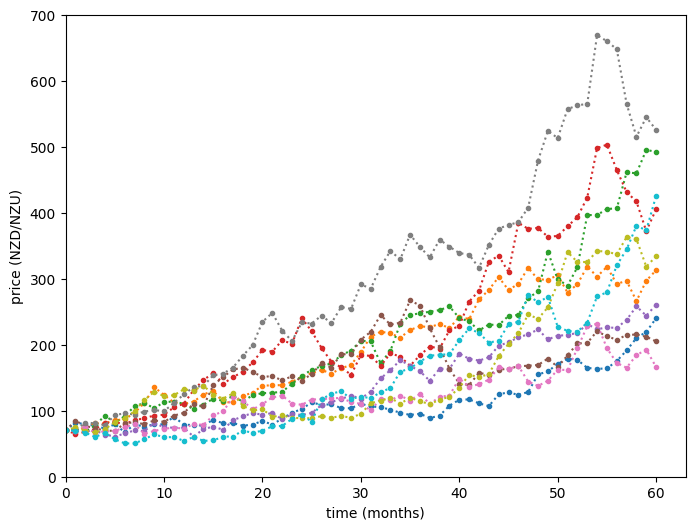

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
for i in range(10):
    ax.plot(projections[i], linestyle=':', marker='.')
ax.set_xlabel('time (months)')
ax.set_ylabel('price (NZD/NZU)')
ax.set_xlim(0)
ax.set_ylim(0)
plt.show()

Now plot the price distribution across all 20000 trajectories at certain future instances: months 12, 24 and 60; or, equivalently, years 1, 2 and 5.

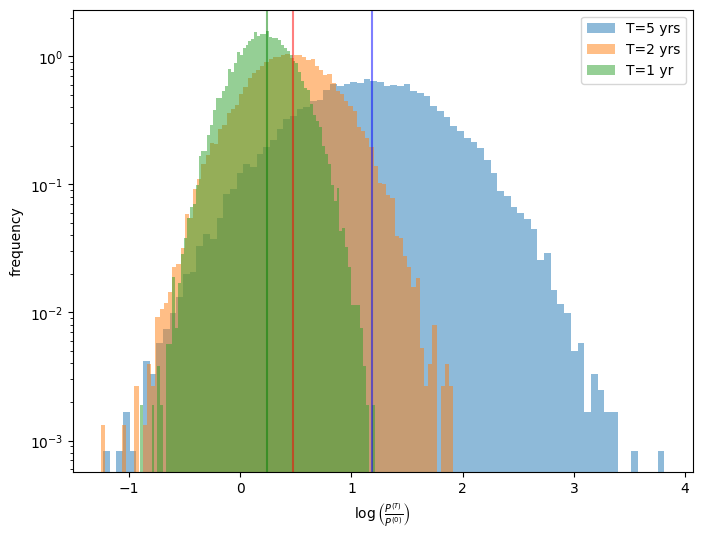

In [10]:
logreturns12 = [np.log(proj[12]/proj[1]) for proj in projections]
logreturns24 = [np.log(proj[24]/proj[1]) for proj in projections]
logreturns60 = [np.log(proj[60]/proj[1]) for proj in projections]

fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel(r'$\log\left(\frac{P^{(T)}}{P^{(0)}}\right)$')
ax.set_ylabel('frequency')
ax.hist(logreturns60, bins='auto', alpha=0.5, density=True, label='T=5 yrs')
ax.hist(logreturns24, bins='auto', alpha=0.5, density=True, label='T=2 yrs')
ax.hist(logreturns12, bins='auto', alpha=0.5, density=True, label='T=1 yr')
ax.axvline(x=60*drift, color='b', alpha=0.5)
ax.axvline(x=24*drift, color='r', alpha=0.5)
ax.axvline(x=12*drift, color='g', alpha=0.5)
ax.legend()
plt.yscale('log')
plt.show()

The above distributions look a lot smoother and have a better defined shape than the ones based on historical data. The modelled distribution's mean is shifting to the right with $T$, consistent with an upward drift in price. The distribution's spread also increases with $T$, as expected in a GBM model.

### 5-year projections

Now let's plot the historical data, a sample set of projections based simulate using Monte Carlo, and the analytically known ensemble average of the GBM model fitted to the historical data. I've separated out the code into a separate function called `gbm_forecast`, which needs to be imported. 

In [11]:
from functions import gbm_forecast
print(gbm_forecast.__doc__)


    Function returning a matplotlib figure, plotting the supplied 
    time-series data and a projection based on the assumption that
    the price dynamics follows geometric brownian motion (GBM).

    INPUTS:
    ------
    
    df - Pandas dataframe with a 'price' column and indexed by datetime.
    
    tscale - string specifying the forecasting time-step: 
             'days', 'weeks', 'months', or 'years'.
    
    nsteps - integer specifying the number of time-steps into the
             future to be forecasted.
    
    nsims - integer specifying the number of feasible trajectories 
            to be simulated using MC and then plotted.
    
    ymax - positive number setting the figure's maximum y-value.
    
    date_range - 2-tuple of pandas timestamps bracketing a range of
                 datetime indices, selecting a subset of values to train 
                 the GBM model. By default, use the entire dataframe.
    
    OUTPUT:
    ------

    fig - Matplotlib figure ob

Now let us use the above function to generate a 5-year forecast from the monthly average of the historical price data.

In [12]:
date_range = df_w.index
#df_w[ df_w.index.isin(date_range)]
#df_w
isinstance(date_range, pd.DatetimeIndex)

True

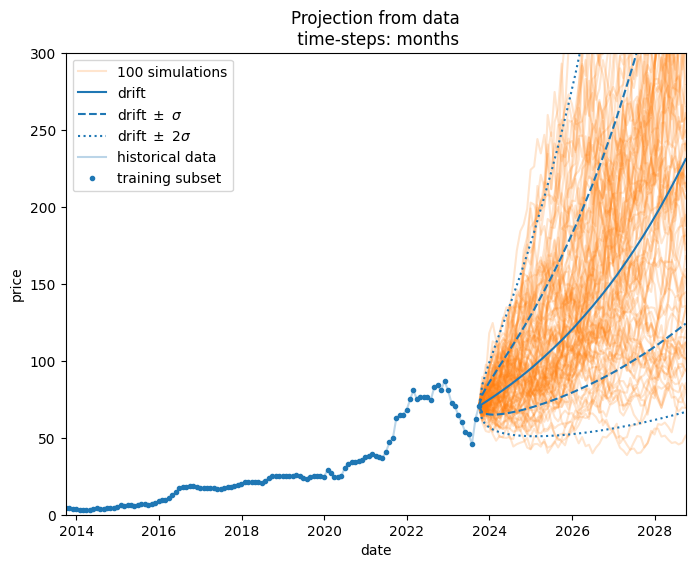

In [13]:
fig = gbm_forecast(df_m)

In [14]:
df.index[0]

Timestamp('2013-09-13 00:00:00')

In the above figure, there are 100 simulated trajectories plotted in red, each of which should be interpreted as a possible future scenario. Each of these model scenarios should be seen as equally likely, and together they illustrate a degree of uncertainty about how the price dynamics could pan out over the next 5 years. However, using the analytic properties of the underlying GBM model, we know how to calculate the ensemble average of all these possible trajectories, which in the present case shows an upward drift. The calculated drift is plotted as a solid blue line, representing the mean behaviour of all forecast trajectories. Since this is a probabilistic model, drawn conclusions should also be expressed in terms of probabilities. That is, the model predicts that, at any point in the future, the probability that the price of NZUs will be below the drift line is 0.5. 

For illustration, the model forecast includes envelopes defined by one standard deviation ($\sigma$) and two standard deviations ($2\sigma$). From our model construction, it follows that the probability of forecasted prices falling inside these envelope is about 0.682 and 0.954, respectively. The above forecast suggests that the probability of NZU prices after 2028 being lower than they are today are quite slim, less than 3%. 

Now let us check if our conclusions change if we consider weekly averaging instead of monthly averaging. Thankfully, that's not the case.

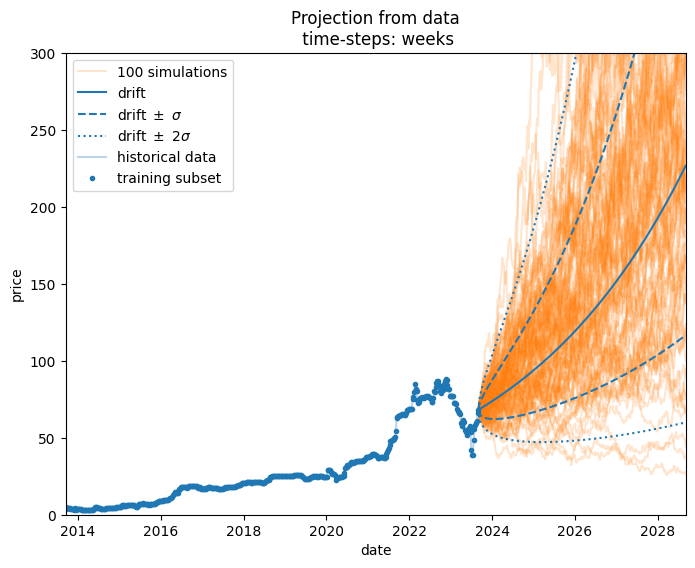

In [15]:
fig = gbm_forecast(df_w, tscale='weeks', nsteps=261)

Note that our forecasts would have looked more pessimistic if they were made just before mid-July, when NZUs were briefly trading below $40, hitting an 18-month low. The price rebounded in August, after the government was compelled to reconsider CCC's advice on the ETS auction settings. For illustration, let us exclude the more recent data points and make a 5-year projection from July 2023, and then compare the projection with what actually panned in the following month.  

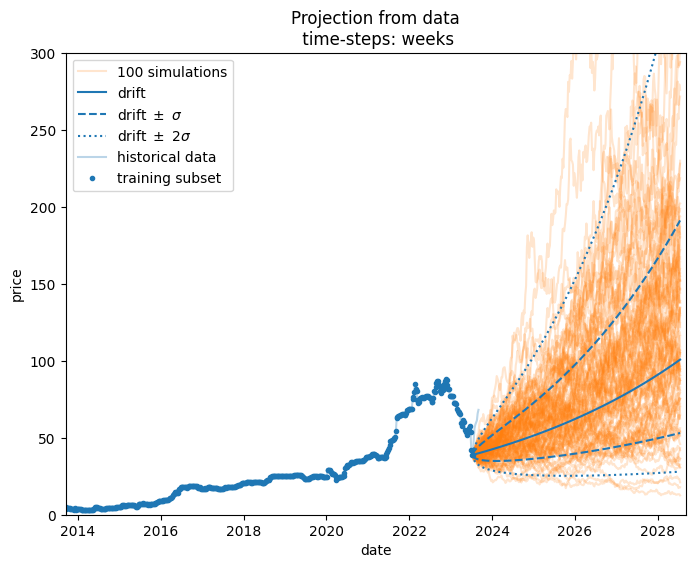

In [16]:
fig = gbm_forecast(df_w, tscale='weeks', nsteps=261, date_range=(df_w.index[0],pd.to_datetime('2023-07-20')))

The translucent datapoints clearly exceeded the expectations based on forecasts starting from end of July 2023. This comparison clearly shows that statistical forecasts based solely on historical data are quite limited. Knowledge (and understanding) of underlying mechanisms that influence the data is more important, but, unfortunately, not alway available.

### Interactive plot

For easier exploration, let us use the `SelectionRangeSlider` widget from the Jupyter Widgets library to create an interactive plot, where the time window for training the model can be adjusted more readily.

In [17]:
import ipywidgets as widgets

dates = df_w.index
options = [(date.strftime(' %d/%m/%y '), date) for date in dates]
index = (0, len(options)-1)

range_slider = widgets.SelectionRangeSlider(options=options,
                                            index=index,
                                            description='Dates',
                                            orientation='horizontal',
                                            layout={'width': '400px'}
                                           )

ifig = widgets.interactive(gbm_forecast,
                           df = widgets.fixed(df_w),
                           tscale = widgets.fixed('weeks'),
                           nsteps = widgets.fixed(261),
                           ymax = widgets.fixed(300),
                           nsims = widgets.fixed(10),
                           date_range = range_slider
                          )

ifig

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 520), layout=Layout(width='400px'), …

The above plot could be packaged and deployed as a web app, using Streamlit, Dash, or something like that.

## NZU monthly transfers

In [18]:
#source='https://www.epa.govt.nz/assets/Uploads/Documents/Emissions-Trading-Scheme/Reports/Carbon-markets/NZETR-unit-transfers.xlsx'
source='NZETR-unit-transfers.xlsx'
headers = {'User-Agent': 'pandas'}

df_trans = pd.read_excel(source, header=1, parse_dates=[0], skipfooter=2, 
                         engine='openpyxl') 
# including storage_options=headers temporarily solved BadZipFile error... 

df_trans.rename(columns={'Month and Year':'date'}, inplace=True)
df_trans.set_index('date', inplace=True)

In [19]:
df_trans
#pd.show_versions()

,AAU,CER,ERU,RMU,NZU,Total
date,,,,,,
2008-01-01,0,0.0,0,0,0,0
2008-02-01,0,0.0,0,0,0,0
2008-03-01,0,108.0,0,0,0,108
2008-04-01,0,20.0,0,0,0,20
2008-05-01,0,0.0,0,0,0,0
...,...,...,...,...,...,...
2023-04-01,0,0.0,0,0,24544252,24544252
2023-05-01,0,0.0,0,0,13755763,13755763
2023-06-01,0,0.0,0,0,19253519,19253519


<AxesSubplot: xlabel='date'>

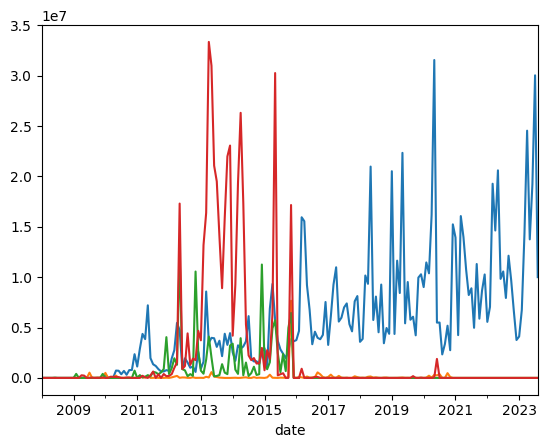

In [20]:
ax = df_trans["NZU"].plot()
df_trans["AAU"].plot(ax=ax)
df_trans["CER"].plot(ax=ax)
df_trans["ERU"].plot(ax=ax)

## NZU voluntary cancellations

In [21]:
#source='https://www.epa.govt.nz/assets/Uploads/Documents/Emissions-Trading-Scheme/Reports/Voluntary-unit-cancellations.xlsx'
source='Voluntary-unit-cancellations.xlsx'
headers = {'User-Agent': 'panda'}

# Spotted a typo in row 1602 of the spreadsheet: the cancellation date is typed as 
# 26/04/203 instead of 04/26/2023. I've emailed the EPA asking them to correct the typo.
df_cans = pd.read_excel(source, header=1, usecols="B,E,F", skipfooter=3, 
                        parse_dates=[0], date_format='mixed',
                        engine='openpyxl') 

df_cans.rename(columns={'Cancellation Date':'date', 'Number of units per cancellation':'units', 'Unit Type':'type'}, inplace=True)
df_cans = df_cans[df_cans['units'].notna()]
df_cans.reset_index(drop=True, inplace=True)
df_cans['date'].ffill(inplace=True)
df_cans

,date,units,type
0,2012-10-02,5.0,NZU
1,2017-05-04,2163.0,AAU
2,2017-05-12,3331.0,AAU
3,2017-05-12,30.0,AAU
4,2018-02-13,7011.0,AAU
...,...,...,...
1736,2015-06-29,120000.0,CER
1737,2020-10-05,98559.0,AAU
1738,2021-02-25,24354.0,AAU
1739,2021-05-03,37500.0,AAU


In [22]:
df_cans_NZU = df_cans.loc[df_cans['type'] == 'NZU']
df_cans_NZU.reset_index(drop=True, inplace=True)
df_cans_NZU

,date,units,type
0,2012-10-02,5.0,NZU
1,2019-04-08,1653.0,NZU
2,2021-11-05,10.0,NZU
3,2021-11-05,130.0,NZU
4,2021-11-05,27.0,NZU
...,...,...,...
250,2013-11-29,8991.0,NZU
251,2014-11-10,9052.0,NZU
252,2016-09-16,15788.0,NZU
253,2017-11-10,5871.0,NZU


<AxesSubplot: xlabel='date'>

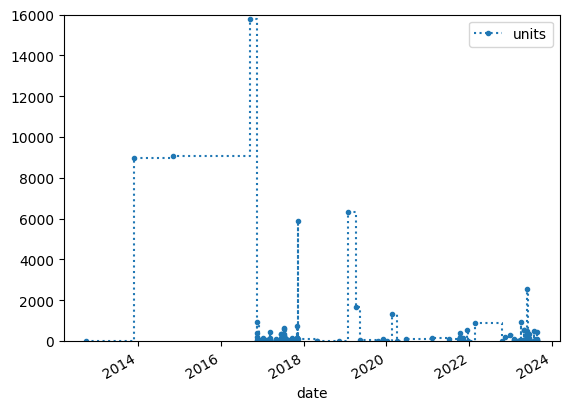

In [23]:
df_cans_NZU.plot('date', 'units', ylim=[0,16000], linestyle=':', drawstyle="steps-post", marker='.')

Changing the above plot to a bar chart causes overcrowding of tick labels along the x-axis, which is an issue already raised on StackOverflow: https://stackoverflow.com/questions/30133280/pandas-bar-plot-changes-date-format 

## Brent oil price data

In [ ]:
# Brent price history
source='https://www.eia.gov/dnav/pet/hist_xls/RBRTEd.xls'
headers = {'User-Agent': 'panda'}
df_brent = pd.read_excel(source, sheet_name=1,header=2,parse_dates=[0],storage_options=headers)
df_brent.rename(columns={'Date':'date',df_brent.columns[1]:'price'}, inplace=True)
df_brent.set_index('date', inplace=True)

In [ ]:
df_brent_w = df_brent.resample('W').mean()
#df_w.ffill(inplace=True) # forward fill missing values
df_brent_m = df_brent.resample('M').mean()
print(len(df_brent), len(df_brent_w), len(df_brent_m))

In [ ]:
ax = df_brent['price'].plot()
df_brent_w['price'].plot(ax = ax)
df_brent_m['price'].plot(ax = ax)
ax.legend(labels = ['raw data','weekly ave','monthly ave'])

In [ ]:
logreturns = [np.log(df_brent['price'].iloc[i]/df_brent['price'].iloc[i-1]) for 
              i in range(1,len(df_brent['price']))]
plt.hist(logreturns, bins=60, density=True)
plt.yscale('log')
plt.show()

In [ ]:
min(logreturns)

In [ ]:
fig = gbm_forecast(df_brent, tscale='days', nsteps = 1825)

In [ ]:
fig = gbm_forecast(df_brent_w, tscale='weeks', nsteps = 261)

In [ ]:
fig = gbm_forecast(df_brent_m, tscale='months', nsteps = 60)